# Model
- Arima model
- Propet
- LSTM

In [1]:
!pip install pmdarima
!pip install fbprophet

     |████████████████████████████████| 1.5MB 5.6MB/s 
     |████████████████████████████████| 2.1MB 20.5MB/s 
     |████████████████████████████████| 9.5MB 33.6MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import io , os , time ,requests,json,bs4
from time import sleep
# import lxml.etree as xml
# import pandas_datareader as pdr
# from yahoo_finance import Share
import matplotlib.pyplot as plt
%matplotlib inline

# model
import pmdarima as pm
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
# init 
datapath = '/mnt/c/Users/poom/drive/01project/01cap_stone/04data/01stockprice'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# load data
df_final= pd.read_csv(os.path.join(datapath,'df_final2.csv'))

## ARIMA

In [ ]:
# test model with 'TSLA'
df_TSLA = df_final[df_final['name'] == 'TSLA'][['Date', 'Adj Close']]
df_TSLA['Date'] = pd.to_datetime(df_TSLA['Date'],format= '%Y-%m-%d')
df_TSLA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1498 entries, 8988 to 10485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1498 non-null   datetime64[ns]
 1   Adj Close  1498 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 35.1 KB


In [ ]:
df_TSLA.set_index('Date',inplace=True)
df_TSLA = df_TSLA.asfreq('b')
df_TSLA.fillna(method='ffill',inplace=True)
df_TSLA.isna().sum().sum()

0

In [ ]:
df_TSLA.head()

,Adj Close
Date,
2015-01-22,40.324001
2015-01-23,40.257999
2015-01-26,41.310001
2015-01-27,41.195999
2015-01-28,39.874001


In [ ]:
data_init= df_TSLA
train_len = int((data_init.shape[0] * 0.95))

y_train = data_init.iloc[:train_len]
y_test  = data_init.iloc[train_len:]

print(f"{train_len} train samples")
print(f"{data_init.shape[0] - train_len} test samples")


1473 train samples
78 test samples


In [ ]:
# model long period
# Create Model Arima แบบ Long Period
data=y_train
model = pm.auto_arima(data['Adj Close'], start_p=0, start_q=0,test='adf',# use adftest to find optimal 'd'
                      max_p=3, max_q=3,max_d=3, # maximum p and q
                      m=10,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   #Seasonality
                      start_P=0,start_Q=0, 
                      max_P=3, max_Q=3,max_D=3,
                      D=1, 
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True, 
                      stepwise=True,random_state=10,n_fits=10)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[10]             : AIC=9367.621, Time=0.48 sec
 ARIMA(1,1,0)(1,1,0)[10]             : AIC=9091.157, Time=0.70 sec
 ARIMA(0,1,1)(0,1,1)[10]             : AIC=8806.409, Time=1.07 sec
 ARIMA(0,1,1)(0,1,0)[10]             : AIC=9369.258, Time=0.25 sec
 ARIMA(0,1,1)(1,1,1)[10]             : AIC=8801.914, Time=1.23 sec
 ARIMA(0,1,1)(1,1,0)[10]             : AIC=9091.159, Time=0.74 sec
 ARIMA(0,1,1)(2,1,1)[10]             : AIC=8740.798, Time=2.34 sec
 ARIMA(0,1,1)(2,1,0)[10]             : AIC=8787.053, Time=1.70 sec
 ARIMA(0,1,1)(3,1,1)[10]             : AIC=8728.609, Time=4.79 sec
 ARIMA(0,1,1)(3,1,0)[10]             : AIC=8730.812, Time=2.55 sec
 ARIMA(0,1,1)(3,1,2)[10]             : AIC=8730.038, Time=6.37 sec
 ARIMA(0,1,1)(2,1,2)[10]             : AIC=8740.983, Time=4.14 sec
 ARIMA(0,1,0)(3,1,1)[10]             : AIC=8726.609, Time=2.64 sec
 ARIMA(0,1,0)(2,1,1)[10]             : AIC=8739.262, Time=1.38 sec
 ARIMA(0,1,0)(3,1,0

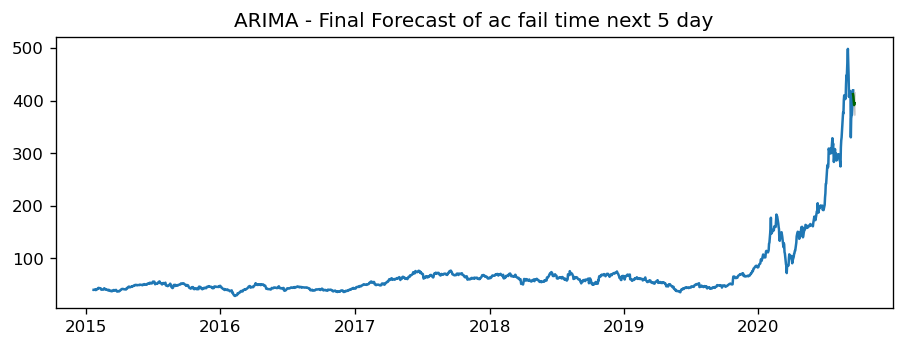

In [ ]:
#plot 
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
n_periods = 5
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='B')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("ARIMA - Final Forecast of ac fail time next 5 day")
plt.show()

Split train test

In [ ]:
data_init = df_TSLA
train_len_a = int((data_init.shape[0] * 0.95))
train_data_a, test_data_a = data_init[:train_len_a], data_init[train_len_a:]

y_train_a = train_data_a['Adj Close'].values
y_test_a = test_data_a['Adj Close'].values

print(f"{train_len_a} train samples")
print(f"{data_init.shape[0] - train_len_a} test samples")

1473 train samples
78 test samples


In [ ]:
model.fit(y_train_a)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(3, 1, 1, 10),
      suppress_warnings=True, with_intercept=False)

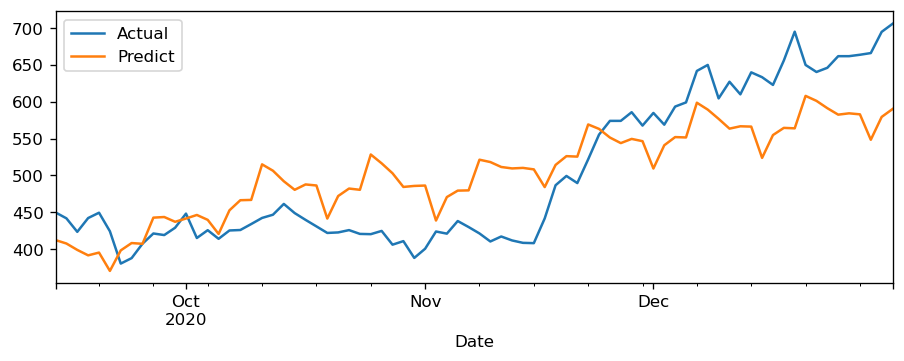

In [ ]:
future_forecast_a = model.predict(n_periods=78)
future_forecast_a = pd.DataFrame(future_forecast_a,index = test_data_a.index,columns=['Predict'])
pd.concat([test_data_a,future_forecast_a],axis=1).plot().legend(["Actual",'Predict'])

In [ ]:
#Create Function Evaluate Model
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

#หาค่า Accuracy ของ Model Arima Long Period
forecast_accuracy(future_forecast_a['Predict'], y_test_a)

{'mape': 0.10966076813828504,
 'me': 2.9285763122955735,
 'mae': 54.169817796466255,
 'mpe': 0.025199882986354522,
 'rmse': 62.93528123214004,
 'corr': 0.8055609814373282,
 'minmax': 0.09999417985699444}

### We got RMSE of 62.9. Which is around 8.7% of current TSLA price ($705)

## Decrease time frame from 5 to 2 years (start data = 2019-01-01, end date = today)

In [ ]:
df_final_short = df_final[df_final['name'] == 'TSLA']

df_final_short= df_final_short[df_final_short['Date']>='2019-01-01']
df_final_short=df_final_short[['Date','Adj Close']]
df_final_short['Date']=pd.to_datetime(df_final_short['Date'],format='%Y-%m-%d')
df_final_short.set_index('Date',inplace=True)
df_final_short=df_final_short.asfreq('b')
df_final_short.fillna(method='ffill',inplace=True)
df_final_short


,Adj Close
Date,
2019-01-02,62.023998
2019-01-03,60.071999
2019-01-04,63.537998
2019-01-07,66.991997
2019-01-08,67.070000
...,...
2020-12-25,661.770020
2020-12-28,663.690002
2020-12-29,665.989990


In [ ]:
#Split Train Test Data Dataframe ที่เริ่มต้นที่เวลา 2019-01-01
data1_init= df_final_short
train_len = int((data1_init.shape[0] * 0.95))

y_train1 = data1_init.iloc[:train_len]
y_test1  = data1_init.iloc[train_len:]

print(f"{train_len} train samples")
print(f"{data1_init.shape[0] - train_len} test samples")


495 train samples
27 test samples


In [ ]:
# Create Model Arima แบบ Short Period
import pmdarima as pm
data1= y_train1
model1 = pm.auto_arima(data1['Adj Close'], start_p=0, start_q=0,test='adf',# use adftest to find optimal 'd'
                      max_p=3, max_q=2,max_d=2, # maximum p and q
                      m=20,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=True,   #Seasonality
                      start_P=0,start_Q=0, 
                      max_P=5, max_Q=3,max_D=3,
                      D=1, 
                      trace=True,
                      error_action='warn',  
                      suppress_warnings=True, 
                      stepwise=True,random_state=10,n_fits=10)

print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[20]             : AIC=3824.644, Time=0.20 sec
 ARIMA(1,1,0)(1,1,0)[20]             : AIC=3731.912, Time=0.57 sec
 ARIMA(0,1,1)(0,1,1)[20]             : AIC=inf, Time=2.26 sec
 ARIMA(1,1,0)(0,1,0)[20]             : AIC=3825.777, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[20]             : AIC=3670.980, Time=1.67 sec
 ARIMA(1,1,0)(3,1,0)[20]             : AIC=3645.014, Time=3.26 sec
 ARIMA(1,1,0)(4,1,0)[20]             : AIC=3610.115, Time=8.40 sec
 ARIMA(1,1,0)(5,1,0)[20]             : AIC=3610.581, Time=22.60 sec
 ARIMA(1,1,0)(4,1,1)[20]             : AIC=3602.576, Time=25.15 sec
 ARIMA(1,1,0)(3,1,1)[20]             : AIC=3604.916, Time=14.39 sec
 ARIMA(1,1,0)(5,1,1)[20]             : AIC=3602.567, Time=44.10 sec
 ARIMA(1,1,0)(5,1,2)[20]             : AIC=3603.252, Time=91.15 sec


In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
n_periods = 5
fitted, confint = model1.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data1.index[-1], periods = n_periods, freq='B')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data1)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("ARIMA - Final Forecast of ac fail time next 5 day")
plt.show()

In [ ]:
data1_init= df_TSLA_short
train_len1_a = int((data1_init.shape[0] * 0.95))
train_data1_a, test_data1_a = data1_init[:train_len1_a], data1_init[train_len1_a:]

y_train1_a = train_data1_a['Adj Close'].values
y_test1_a = test_data1_a['Adj Close'].values

print(f"{train_len1_a} train samples")
print(f"{data1_init.shape[0] - train_len1_a} test samples")

In [ ]:
model1.fit(y_train1_a)

In [ ]:
future_forecast1_a = model1.predict(n_periods=23)
future_forecast1_a = pd.DataFrame(future_forecast1_a,index = test_data1_a.index,columns=['Predict'])
pd.concat([test_data1_a,future_forecast1_a],axis=1).plot().legend(["Actual",'Predict'])

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})


forecast_accuracy(future_forecast1_a['Predict'], y_test1_a)

Short time frame Data has better RMSE (123)

## Time Series modeling Facebook Prophet

### From this section move to Google colab for more demanding work

In [ ]:
!conda install -c conda-forge fbprophet

Solving environment: done

## Package Plan ##

  environment location: /mnt/c/Users/poom/drive/72client/miniconda3/envs/stock_ai

  added / updated specs:
    - fbprophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    binutils_impl_linux-64-2.31.1|       h6176602_1         3.9 MB
    binutils_linux-64-2.31.1   |       h6176602_9          26 KB
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    certifi-2020.12.5          |   py36h5fab9bb_0         143 KB  conda-forge
    convertdate-2.1.3          |          py_1000          30 KB  conda-forge
    cython-0.29.21             |   py36ha357f81_1         2.1 MB  conda-forge
    ephem-3.7.7.1              |   py36h8c4c3a4_1         761 KB  conda-forge
    fbprophet-0.7.1            |   py36h831f99a_0         684 KB  conda-forge
    gcc_impl_linux-64-7.3.0    |       habb00fd_1        41.9 MB
    gcc_linux-64-7

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_final = pd.read_csv("/content/drive/My Drive/df_final2.csv")
df_final.head()

,Date,High,Low,Open,Volume,Adj Close,ema10,ema20,ema75,macd,macd_signal_line,rsi,L14,H14,%K,%D,name,COILOpen,COILHigh,COILLow,COILClose,COILAdj Close,COILVolume,DJIOpen,DJIHigh,DJILow,DJIClose,DJIAdj Close,DJIVolume,EURUSDOpen,EURUSDHigh,EURUSDLow,EURUSDClose,EURUSDAdj Close,EURUSDVolume,GOLDOpen,GOLDHigh,GOLDLow,GOLDClose,GOLDAdj Close,...,IXICAdj Close,IXICVolume,N225Open,N225High,N225Low,N225Close,N225Adj Close,N225Volume,NGFOpen,NGFHigh,NGFLow,NGFClose,NGFAdj Close,NGFVolume,NYAOpen,NYAHigh,NYALow,NYAClose,NYAAdj Close,NYAVolume,SILVEROpen,SILVERHigh,SILVERLow,SILVERClose,SILVERAdj Close,SILVERVolume,SP500Open,SP500High,SP500Low,SP500Close,SP500Adj Close,SP500Volume,USDCNYOpen,USDCNYHigh,USDCNYLow,USDCNYClose,USDCNYAdj Close,USDCNYVolume,compound,GGTrendAllTimeMonthly
0,2015-01-22,28.117500,27.430000,27.565001,215185600.0,25.597706,24.955144,25.045723,25.371346,-0.144608,-0.192319,54.163214,26.157499,28.312500,90.139232,63.747240,AAPL,47.349998,49.090000,45.869999,46.310001,46.310001,426829.0,17557.289063,17840.890625,17482.539063,17813.980469,17813.980469,111980000.0,1.161697,1.164289,1.141400,1.161535,1.161535,0.0,1293.199951,1302.099976,1283.500000,1300.699951,1300.699951,...,4750.399902,1.996550e+09,17306.640625,17355.740234,17229.210938,17329.019531,17329.019531,121900.0,3.000,3.048,2.766,2.835,2.835,169450.0,10753.580078,10869.000000,10699.730469,10859.349609,10859.349609,4.176050e+09,18.346001,18.346001,18.346001,18.346001,18.346001,0.0,2034.300049,2064.620117,2026.380005,2063.149902,2063.149902,4.176050e+09,6.2017,6.2020,6.1986,6.2017,6.2017,0.0,0.0,0.0
1,2015-01-23,28.437500,27.882500,28.075001,185859200.0,25.729790,25.095989,25.110872,25.380778,-0.072844,-0.168424,57.671228,26.157499,28.437500,91.557057,79.590968,AAPL,46.630001,47.759998,45.209999,45.590000,45.590000,374289.0,17812.500000,17812.500000,17667.529297,17672.599609,17672.599609,97110000.0,1.134649,1.137398,1.112180,1.134675,1.134675,0.0,1299.800049,1299.800049,1292.599976,1292.599976,1292.599976,...,4757.879883,1.653830e+09,17520.630859,17532.060547,17460.759766,17511.750000,17511.750000,132500.0,2.858,2.994,2.855,2.986,2.986,99068.0,10854.230469,10854.230469,10784.570313,10788.330078,10788.330078,3.573560e+09,18.315001,18.355000,18.284000,18.284000,18.284000,20.0,2062.979980,2062.979980,2050.540039,2051.820068,2051.820068,3.573560e+09,6.1990,6.2179,6.1990,6.1990,6.1990,0.0,0.0,0.0
2,2015-01-26,28.590000,28.200001,28.434999,222460000.0,25.757124,25.216195,25.172420,25.390682,-0.013608,-0.137461,66.442618,26.157499,28.590000,87.050342,89.582210,AAPL,45.200001,46.410000,44.349998,45.150002,45.150002,310638.0,17668.109375,17696.359375,17567.599609,17678.699219,17678.699219,87220000.0,1.114082,1.128399,1.114082,1.112545,1.112545,0.0,1289.500000,1290.599976,1279.400024,1279.400024,1279.400024,...,4771.759766,1.717510e+09,17285.710938,17471.939453,17285.710938,17468.519531,17468.519531,111600.0,2.897,2.955,2.841,2.881,2.881,62580.0,10787.299805,10848.040039,10748.730469,10847.150391,10847.150391,3.465760e+09,17.966999,17.966999,17.966999,17.966999,17.966999,0.0,2050.419922,2057.620117,2040.969971,2057.090088,2057.090088,3.465760e+09,6.2179,6.2458,6.2179,6.2179,6.2179,0.0,0.0,0.0
3,2015-01-27,28.120001,27.257500,28.105000,382274800.0,24.855284,25.150575,25.142216,25.376593,-0.038984,-0.117766,55.811122,26.299999,28.590000,43.013110,73.873503,AAPL,45.130001,46.549999,44.810001,46.230000,46.230000,313141.0,17638.529297,17638.529297,17288.310547,17387.210938,17387.210938,135940000.0,1.125100,1.142000,1.122600,1.124771,1.124771,0.0,1277.199951,1291.699951,1277.199951,1291.699951,1291.699951,...,4681.500000,1.954160e+09,17649.400391,17768.410156,17633.470703,17768.300781,17768.300781,139700.0,2.895,3.005,2.888,2.981,2.981,55623.0,10793.040039,10830.200195,10718.849609,10781.830078,10781.830078,3.329810e+09,18.110001,18.110001,18.068001,18.068001,18.068001,10.0,2047.859985,2047.859985,2019.910034,2029.550049,2029.550049,3.329810e+09,6.2458,6.2458,6.2351,6.2458,6.2

In [ ]:
data2_init = df_final[df_final['name'] == 'TSLA']
data2_init=data2_init[['Date','Adj Close']]
data2_init=data2_init[data2_init['Date']>='2019-01-01']
data2_init.rename(columns={'Date':'ds','Adj Close':'y'},inplace=True)

train2_len = int((data2_init.shape[0] * 0.95))

y_train2 = data2_init.iloc[:train2_len]
y_test2  = data2_init.iloc[train2_len:]

print(f"{train2_len} train samples")
print(f"{data2_init.shape[0] - train2_len} test samples")

479 train samples
26 test samples


In [ ]:
y_train2.head()

,ds,y
9981,2019-01-02,62.023998
9982,2019-01-03,60.071999
9983,2019-01-04,63.537998
9984,2019-01-07,66.991997
9985,2019-01-08,67.070000


In [ ]:
model2 = Prophet()
# fit the model
model2.fit(y_train2)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds        yhat  yhat_lower  yhat_upper
0  2020-11-24  497.728761  464.690418  528.400760
1  2020-11-25  500.055669  466.678553  532.292791
2  2020-11-27  502.067396  473.290529  534.241446
3  2020-11-30  508.198498  475.109739  541.996376
4  2020-12-01  509.579428  479.704924  541.085983
5  2020-12-02  511.906335  481.661670  542.802570
6  2020-12-03  513.206838  482.201716  544.199475
7  2020-12-04  513.918063  479.862947  544.423708
8  2020-12-07  520.049164  488.816460  550.822178
9  2020-12-08  521.430095  488.781729  554.744301
10 2020-12-09  523.757002  493.493537  557.666419
11 2020-12-10  525.057505  494.893763  558.882924
12 2020-12-11  525.768730  491.149081  557.415873
13 2020-12-14  531.899831  501.426559  563.903796
14 2020-12-15  533.280762  502.945771  565.359784
15 2020-12-16  535.607669  503.757142  566.905260
16 2020-12-17  536.908172  507.670907  567.731789
17 2020-12-18  537.619397  505.471980  569.923445
18 2020-12-21  543.750498  510.580516  574.441985


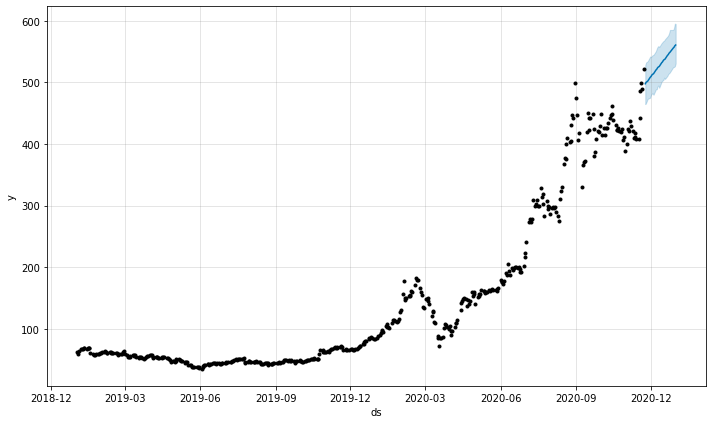

In [ ]:
# define the period for which we want a prediction
pro_change= Prophet(n_changepoints=21)
future=y_test2[['ds']]
forecast = model2.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
# plot forecast
model2.plot(forecast)
plt.show()

In [ ]:
data2_init
train_len2_a = int((data2_init.shape[0] * 0.95))
train_data2_a, test_data2_a = data2_init[:train_len2_a], data2_init[train_len2_a:]

y_train2_a = train_data2_a['y'].values
y_test2_a = test_data2_a['y'].values

print(f"{train_len2_a} train samples")
print(f"{data2_init.shape[0] - train_len2_a} test samples")

479 train samples
26 test samples


In [ ]:
future_forecast2_a = model2.predict(future)
future_forecast2_a.tail(5)
future_forecast2_a.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'], dtype='object')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



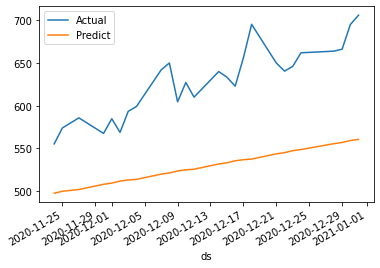

In [ ]:
test_data2_a['ds']=pd.to_datetime(test_data2_a['ds'],format='%Y-%m-%d')
test_data2_a.set_index('ds',inplace=True)
future_forecast2_a =future_forecast2_a[['ds','yhat']]
future_forecast2_a.set_index('ds',inplace=True)
pd.concat([test_data2_a,future_forecast2_a],axis=1).plot().legend(["Actual",'Predict'])

In [ ]:
test_data2_a

,y
ds,
2020-11-24,555.380005
2020-11-25,574.000000
2020-11-27,585.760010
2020-11-30,567.599976
2020-12-01,584.760010
2020-12-02,568.820007
2020-12-03,593.380005
2020-12-04,599.039978
2020-12-07,641.760010


In [ ]:
!pip install statsmodels.tsa.stattools

import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})


forecast_accuracy(future_forecast2_a.values, test_data2_a.values)

ERROR: Could not find a version that satisfies the requirement statsmodels.tsa.stattools (from versions: none)
ERROR: No matching distribution found for statsmodels.tsa.stattools


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2551: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2480: RuntimeWarning:

invalid value encountered in multiply



{'corr': nan,
 'mae': 98.8888414043528,
 'mape': 0.15555008743523688,
 'me': -98.8888414043528,
 'minmax': 0.1555500874352369,
 'mpe': -0.15555008743523688,
 'rmse': 102.12146375355647}

## Multivariate Multistep LSTM

In [ ]:
from matplotlib import pyplot
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
%matplotlib inline

In [ ]:
df_final.head()

,Date,High,Low,Open,Volume,Adj Close,ema10,ema20,ema75,macd,macd_signal_line,rsi,L14,H14,%K,%D,name,COILOpen,COILHigh,COILLow,COILClose,COILAdj Close,COILVolume,DJIOpen,DJIHigh,DJILow,DJIClose,DJIAdj Close,DJIVolume,EURUSDOpen,EURUSDHigh,EURUSDLow,EURUSDClose,EURUSDAdj Close,EURUSDVolume,GOLDOpen,GOLDHigh,GOLDLow,GOLDClose,GOLDAdj Close,...,IXICAdj Close,IXICVolume,N225Open,N225High,N225Low,N225Close,N225Adj Close,N225Volume,NGFOpen,NGFHigh,NGFLow,NGFClose,NGFAdj Close,NGFVolume,NYAOpen,NYAHigh,NYALow,NYAClose,NYAAdj Close,NYAVolume,SILVEROpen,SILVERHigh,SILVERLow,SILVERClose,SILVERAdj Close,SILVERVolume,SP500Open,SP500High,SP500Low,SP500Close,SP500Adj Close,SP500Volume,USDCNYOpen,USDCNYHigh,USDCNYLow,USDCNYClose,USDCNYAdj Close,USDCNYVolume,compound,GGTrendAllTimeMonthly
0,2015-01-22,28.117500,27.430000,27.565001,215185600.0,25.597706,24.955144,25.045723,25.371346,-0.144608,-0.192319,54.163214,26.157499,28.312500,90.139232,63.747240,AAPL,47.349998,49.090000,45.869999,46.310001,46.310001,426829.0,17557.289063,17840.890625,17482.539063,17813.980469,17813.980469,111980000.0,1.161697,1.164289,1.141400,1.161535,1.161535,0.0,1293.199951,1302.099976,1283.500000,1300.699951,1300.699951,...,4750.399902,1.996550e+09,17306.640625,17355.740234,17229.210938,17329.019531,17329.019531,121900.0,3.000,3.048,2.766,2.835,2.835,169450.0,10753.580078,10869.000000,10699.730469,10859.349609,10859.349609,4.176050e+09,18.346001,18.346001,18.346001,18.346001,18.346001,0.0,2034.300049,2064.620117,2026.380005,2063.149902,2063.149902,4.176050e+09,6.2017,6.2020,6.1986,6.2017,6.2017,0.0,0.0,0.0
1,2015-01-23,28.437500,27.882500,28.075001,185859200.0,25.729790,25.095989,25.110872,25.380778,-0.072844,-0.168424,57.671228,26.157499,28.437500,91.557057,79.590968,AAPL,46.630001,47.759998,45.209999,45.590000,45.590000,374289.0,17812.500000,17812.500000,17667.529297,17672.599609,17672.599609,97110000.0,1.134649,1.137398,1.112180,1.134675,1.134675,0.0,1299.800049,1299.800049,1292.599976,1292.599976,1292.599976,...,4757.879883,1.653830e+09,17520.630859,17532.060547,17460.759766,17511.750000,17511.750000,132500.0,2.858,2.994,2.855,2.986,2.986,99068.0,10854.230469,10854.230469,10784.570313,10788.330078,10788.330078,3.573560e+09,18.315001,18.355000,18.284000,18.284000,18.284000,20.0,2062.979980,2062.979980,2050.540039,2051.820068,2051.820068,3.573560e+09,6.1990,6.2179,6.1990,6.1990,6.1990,0.0,0.0,0.0
2,2015-01-26,28.590000,28.200001,28.434999,222460000.0,25.757124,25.216195,25.172420,25.390682,-0.013608,-0.137461,66.442618,26.157499,28.590000,87.050342,89.582210,AAPL,45.200001,46.410000,44.349998,45.150002,45.150002,310638.0,17668.109375,17696.359375,17567.599609,17678.699219,17678.699219,87220000.0,1.114082,1.128399,1.114082,1.112545,1.112545,0.0,1289.500000,1290.599976,1279.400024,1279.400024,1279.400024,...,4771.759766,1.717510e+09,17285.710938,17471.939453,17285.710938,17468.519531,17468.519531,111600.0,2.897,2.955,2.841,2.881,2.881,62580.0,10787.299805,10848.040039,10748.730469,10847.150391,10847.150391,3.465760e+09,17.966999,17.966999,17.966999,17.966999,17.966999,0.0,2050.419922,2057.620117,2040.969971,2057.090088,2057.090088,3.465760e+09,6.2179,6.2458,6.2179,6.2179,6.2179,0.0,0.0,0.0
3,2015-01-27,28.120001,27.257500,28.105000,382274800.0,24.855284,25.150575,25.142216,25.376593,-0.038984,-0.117766,55.811122,26.299999,28.590000,43.013110,73.873503,AAPL,45.130001,46.549999,44.810001,46.230000,46.230000,313141.0,17638.529297,17638.529297,17288.310547,17387.210938,17387.210938,135940000.0,1.125100,1.142000,1.122600,1.124771,1.124771,0.0,1277.199951,1291.699951,1277.199951,1291.699951,1291.699951,...,4681.500000,1.954160e+09,17649.400391,17768.410156,17633.470703,17768.300781,17768.300781,139700.0,2.895,3.005,2.888,2.981,2.981,55623.0,10793.040039,10830.200195,10718.849609,10781.830078,10781.830078,3.329810e+09,18.110001,18.110001,18.068001,18.068001,18.068001,10.0,2047.859985,2047.859985,2019.910034,2029.550049,2029.550049,3.329810e+09,6.2458,6.2458,6.2351,6.2458,6.2

In [ ]:
df_TSLA = df_final[df_final['name'] == 'TSLA']
df_TSLA = df_TSLA[['Date',
 'High',
 'Low',
 'Open',
 'Volume',
 'ema10',
 'ema20',
 'macd',
 'L14',
 'H14',
 'Adj Close']]
df_TSLA.set_index('Date',inplace = True)
df_TSLA.head()

,High,Low,Open,Volume,ema10,ema20,macd,L14,H14,Adj Close
Date,,,,,,,,,,
2015-01-22,40.647999,39.040001,39.400002,20584500.0,40.022211,41.166421,-1.366531,37.0,44.650002,40.324001
2015-01-23,40.700001,39.666000,40.057999,17193000.0,40.065082,41.079905,-1.267136,37.0,43.299999,40.257999
2015-01-26,41.723999,40.209999,40.366001,16172500.0,40.291431,41.101819,-1.090902,37.0,42.956001,41.310001
2015-01-27,41.605999,40.660000,40.883999,13905000.0,40.455898,41.110788,-0.949489,37.0,42.956001,41.195999
2015-01-28,41.273998,39.683998,41.222000,15748000.0,40.350098,40.992999,-0.933334,37.0,42.759998,39.874001


In [ ]:
#Function convert 2D into 3D time series data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
dataset = df_TSLA
values = dataset.values
values = values.astype('float32')

In [ ]:
def list_drop_fea(dataset,previous,predict):
  feature=len(dataset.columns)
  list_drop=[]
  for i in range(0,(feature*(previous+predict))):
   if i < (previous*feature):
      continue
   elif (i-(feature-1))%feature != 0:
      list_drop.append(i)
   else :
      continue
  return list_drop

In [ ]:
# min max scaling

min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())

In [ ]:
reframed = series_to_supervised(dataset.values, 30, 5 ,feat_name=dataset.columns)
#Drop feature list ratede previous time step and Next Time Step 
feature_Drop=list_drop_fea(dataset,30,5)

reframed.drop(reframed.columns[feature_Drop], axis=1, inplace=True)

In [ ]:
reframed.head()

,High(t-30),Low(t-30),Open(t-30),Volume(t-30),ema10(t-30),ema20(t-30),macd(t-30),L14(t-30),H14(t-30),Adj Close(t-30),High(t-29),Low(t-29),Open(t-29),Volume(t-29),ema10(t-29),ema20(t-29),macd(t-29),L14(t-29),H14(t-29),Adj Close(t-29),High(t-28),Low(t-28),Open(t-28),Volume(t-28),ema10(t-28),ema20(t-28),macd(t-28),L14(t-28),H14(t-28),Adj Close(t-28),High(t-27),Low(t-27),Open(t-27),Volume(t-27),ema10(t-27),ema20(t-27),macd(t-27),L14(t-27),H14(t-27),Adj Close(t-27),...,ema20(t-4),macd(t-4),L14(t-4),H14(t-4),Adj Close(t-4),High(t-3),Low(t-3),Open(t-3),Volume(t-3),ema10(t-3),ema20(t-3),macd(t-3),L14(t-3),H14(t-3),Adj Close(t-3),High(t-2),Low(t-2),Open(t-2),Volume(t-2),ema10(t-2),ema20(t-2),macd(t-2),L14(t-2),H14(t-2),Adj Close(t-2),High(t-1),Low(t-1),Open(t-1),Volume(t-1),ema10(t-1),ema20(t-1),macd(t-1),L14(t-1),H14(t-1),Adj Close(t-1),Adj Close(t),Adj Close(t+1),Adj Close(t+2),Adj Close(t+3),Adj Close(t+4)
30,0.014038,0.016337,0.016285,0.056597,0.012571,0.011198,0.214242,0.015459,0.012169,0.017121,0.014113,0.017281,0.017265,0.045336,0.012639,0.011054,0.215699,0.015459,0.010191,0.017024,0.015602,0.018102,0.017724,0.041947,0.012995,0.011091,0.218283,0.015459,0.009687,0.018578,0.015431,0.018781,0.018495,0.034418,0.013254,0.011106,0.220356,0.015459,0.009687,0.018409,...,0.011574,0.228852,0.018372,0.011363,0.015854,0.013165,0.016373,0.016229,0.061834,0.013852,0.011341,0.227808,0.018372,0.010689,0.016513,0.013828,0.016943,0.016955,0.058342,0.013752,0.011220,0.227736,0.018372,0.010689,0.017364,0.014895,0.017830,0.018028,0.069217,0.013567,0.011053,0.227332,0.019089,0.010689,0.016829,0.014834,0.013948,0.013783,0.014793,0.014004
31,0.014113,0.017281,0.017265,0.045336,0.012639,0.011054,0.215699,0.015459,0.010191,0.017024,0.015602,0.018102,0.017724,0.041947,0.012995,0.011091,0.218283,0.015459,0.009687,0.018578,0.015431,0.018781,0.018495,0.034418,0.013254,0.011106,0.220356,0.015459,0.009687,0.018409,0.014948,0.017309,0.018999,0.040537,0.013087,0.010910,0.220592,0.015459,0.009400,0.016457,...,0.011341,0.227808,0.018372,0.010689,0.016513,0.013828,0.016943,0.016955,0.058342,0.013752,0.011220,0.227736,0.018372,0.010689,0.017364,0.014895,0.017830,0.018028,0.069217,0.013567,0.011053,0.227332,0.019089,0.010689,0.016829,0.013313,0.015417,0.016943,0.099690,0.013029,0.010690,0.225516,0.017974,0.010689,0.014834,0.013948,0.013783,0.014793,0.014004,0.013298
32,0.015602,0.018102,0.017724,0.041947,0.012995,0.011091,0.218283,0.015459,0.009687,0.018578,0.015431,0.018781,0.018495,0.034418,0.013254,0.011106,0.220356,0.015459,0.009687,0.018409,0.014948,0.017309,0.018999,0.040537,0.013087,0.010910,0.220592,0.015459,0.009400,0.016457,0.014834,0.016729,0.017497,0.047154,0.013285,0.010918,0.222297,0.015459,0.008280,0.018179,...,0.011220,0.227736,0.018372,0.010689,0.017364,0.014895,0.017830,0.018028,0.069217,0.013567,0.011053,0.227332,0.019089,0.010689,0.016829,0.013313,0.015417,0.016943,0.099690,0.013029,0.010690,0.225516,0.017974,0.010689,0.014834,0.011493,0.014240,0.015508,0.100093,0.012418,0.010266,0.223491,0.016602,0.010689,0.013948,0.013783,0.014793,0.014004,0.013298,0.015372
33,0.015431,0.018781,0.018495,0.034418,0.013254,0.011106,0.220356,0.015459,0.009687,0.018409,0.014948,0.017309,0.018999,0.040537,0.013087,0.010910,0.220592,0.015459,0.009400,0.016457,0.014834,0.016729,0.017497,0.047154,0.013285,0.010918,0.222297,0.015459,0.008280,0.018179,0.015268,0.018690,0.018358,0.038170,0.013355,0.010874,0.223395,0.015459,0.007881,0.017706,...,0.011053,0.227332,0.019089,0.010689,0.016829,0.013313,0.015417,0.016943,0.099690,0.013029,0.010690,0.225516,0.017974,0.010689,0.014834,0.011493,0.014240,0.015508,0.100093,0.012418,0.010266,0.223491,0.016602,0.010689,0.013948,0.011205,0.014044,0.013742,0.080884,0.011885,0.009865,0.221896,0.016374,0.010689,0.013783,0.014793,0.014004,0.013298,0.015372,0.015086
34,0.014948,0.017309,0.018999,0.040537,0.013087,0.010910,0.220592,0.015459,0.009400,0.016457,0.014834,0.016729,0.017497,0.047154,0.013285,0.010918,0.222297,0.015459,0.008280,0.01

In [ ]:
values = reframed.values
n_train_percent = 0.9
split = int(values.shape[0]*n_train_percent)
train = values[:split, :]
test = values[split:, :]

#  datetime ของ train & test
date_reframed = dataset.index[reframed.index]
date_train = date_reframed[:split]
date_test = date_reframed[split:]

# split feature และ target
train_X, train_y = train[:, :-5], train[:, -5:]
test_X, test_y = test[:, :-5], test[:, -5:]

# reshape input to 3D (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

Epoch 1/100
19/19 - 2s - loss: 0.0215 - val_loss: 0.1912
Epoch 2/100
19/19 - 0s - loss: 0.0142 - val_loss: 0.0877
Epoch 3/100
19/19 - 0s - loss: 0.0125 - val_loss: 0.1519
Epoch 4/100
19/19 - 0s - loss: 0.0156 - val_loss: 0.0914
Epoch 5/100
19/19 - 0s - loss: 0.0140 - val_loss: 0.1598
Epoch 6/100
19/19 - 0s - loss: 0.0162 - val_loss: 0.1015
Epoch 7/100
19/19 - 0s - loss: 0.0176 - val_loss: 0.0870
Epoch 8/100
19/19 - 0s - loss: 0.0152 - val_loss: 0.1622
Epoch 9/100
19/19 - 0s - loss: 0.0115 - val_loss: 0.0737
Epoch 10/100
19/19 - 0s - loss: 0.0128 - val_loss: 0.0770
Epoch 11/100
19/19 - 0s - loss: 0.0125 - val_loss: 0.1298
Epoch 12/100
19/19 - 0s - loss: 0.0116 - val_loss: 0.0673
Epoch 13/100
19/19 - 0s - loss: 0.0114 - val_loss: 0.0722
Epoch 14/100
19/19 - 0s - loss: 0.0119 - val_loss: 0.0766
Epoch 15/100
19/19 - 0s - loss: 0.0106 - val_loss: 0.1017
Epoch 16/100
19/19 - 0s - loss: 0.0101 - val_loss: 0.0718
Epoch 17/100
19/19 - 0s - loss: 0.0095 - val_loss: 0.1466
Epoch 18/100
19/19 - 0s

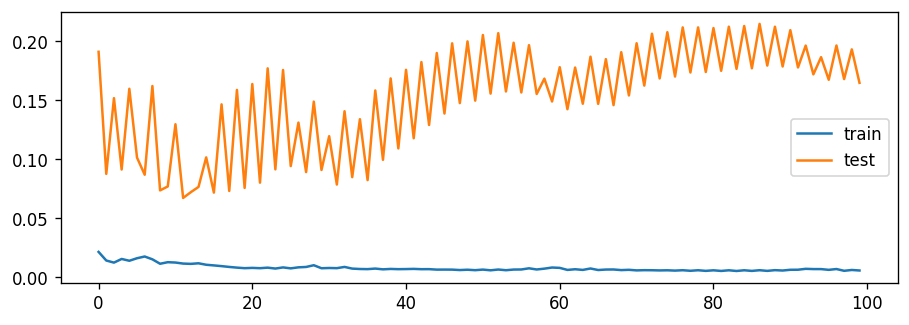

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# สร้าง LSTM network ด้วย library Keras โดยกำหนดขนาด hidden layer(50) และ shape ของข้อมูล input(#rows x #features)
model3 = Sequential()
model3.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))

# สร้าง hidden layer ตามขนาด output หรือ จำนวนวันที่ต้องการ forecast (5) 
model3.add(Dense(5))
model3.compile(loss='mae', optimizer='adam')

# train โมเดล และเก็บ log
history = model3.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# พล็อตค่า train&test loss
pyplot.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# ทำ prediction
yhat = model3.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# rescale ข้อมูลกลับ
inv_yhat = yhat*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']
inv_y = test_y*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']

# พล็อตราคาจริงของวันที่ทำ prediction ล่วงหน้า 3 วัน + ราคาย้อนหลัง 30 วัน (สีน้ำเงิน) และ ราคา forecast (สีแดง)
import numpy as np
idx = np.random.randint(0,len(yhat-5))
if idx <30:
  date_actual = date_test[:idx+5]
else:
  date_actual = date_test[idx-30:idx+5]

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 <a list of 35 Text major ticklabel objects>)

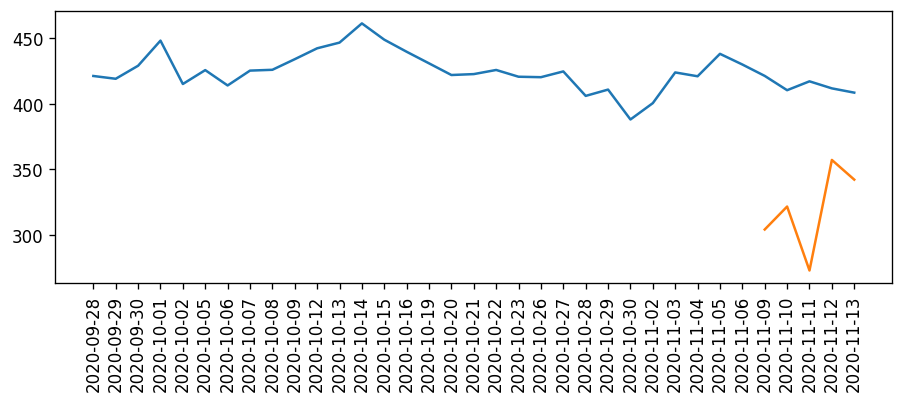

In [ ]:
pyplot.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
pyplot.plot(date_actual,inv_y[max(0,idx-30):idx+5,0],label='Actual+Predict')
pyplot.plot(date_test[idx:idx+5],inv_yhat[idx],label='Predict')
pyplot.xticks(rotation=90)

In [ ]:
import numpy as np
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})


forecast_accuracy(inv_yhat, inv_y)

{'corr': 0.9968092288997169,
 'mae': 111.62087327606824,
 'mape': 0.23862281211390152,
 'me': -110.12242012283428,
 'minmax': 0.23840463238949738,
 'mpe': -0.23108646532340785,
 'rmse': 144.5284150588513}

### Reduced timeframe to 1 year

In [ ]:
df_TSLA = df_final[df_final['name'] == 'TSLA']
df_TSLA = df_TSLA[['Date',
 'High',
 'Low',
 'Open',
 'Volume',
 'ema10',
 'ema20',
 'macd',
 'L14',
 'H14',
 'Adj Close']]
df_TSLA=df_TSLA[df_TSLA['Date']>='2019-01-01']
df_TSLA.set_index('Date',inplace = True)
df_TSLA.head()

,High,Low,Open,Volume,ema10,ema20,macd,L14,H14,Adj Close
Date,,,,,,,,,,
2019-01-02,63.026001,59.759998,61.220001,58293000.0,65.286234,66.686581,-1.252441,58.818001,75.573997,62.023998
2019-01-03,61.880001,59.476002,61.400002,34826000.0,64.338191,66.056621,-1.606889,58.818001,75.573997,60.071999
2019-01-04,63.599998,60.546001,61.200001,36970500.0,64.192702,65.816752,-1.589789,58.818001,75.573997,63.537998
2019-01-07,67.348000,63.549999,64.344002,37756000.0,64.701664,65.928680,-1.282742,58.818001,73.139999,66.991997
2019-01-08,68.802002,65.403999,68.391998,35042500.0,65.132271,66.037377,-1.021337,58.818001,70.309998,67.070000


In [ ]:
dataset = df_TSLA
values = dataset.values
values = values.astype('float32')

In [ ]:
# ทำ scaling ข้อมูลด้วยวิธี min max scaling เปลี่ยน scale ข้อมูลแต่ละ column ให้อยู่ระหว่าง [0,1] และเก็บค่า min max แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())

In [ ]:
# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้

reframed = series_to_supervised(dataset.values, 30, 7 ,feat_name=dataset.columns)
#Drop feature list ratede previous time step and Next Time Step 
feature_Drop=list_drop_fea(dataset,30,7)

reframed.drop(reframed.columns[feature_Drop], axis=1, inplace=True)

In [ ]:
reframed.head()

,High(t-30),Low(t-30),Open(t-30),Volume(t-30),ema10(t-30),ema20(t-30),macd(t-30),L14(t-30),H14(t-30),Adj Close(t-30),High(t-29),Low(t-29),Open(t-29),Volume(t-29),ema10(t-29),ema20(t-29),macd(t-29),L14(t-29),H14(t-29),Adj Close(t-29),High(t-28),Low(t-28),Open(t-28),Volume(t-28),ema10(t-28),ema20(t-28),macd(t-28),L14(t-28),H14(t-28),Adj Close(t-28),High(t-27),Low(t-27),Open(t-27),Volume(t-27),ema10(t-27),ema20(t-27),macd(t-27),L14(t-27),H14(t-27),Adj Close(t-27),High(t-26),Low(t-26),Open(t-26),Volume(t-26),ema10(t-26),ema20(t-26),macd(t-26),L14(t-26),H14(t-26),Adj Close(t-26),High(t-25),Low(t-25),Open(t-25),Volume(t-25),ema10(t-25),ema20(t-25),macd(t-25),L14(t-25),H14(t-25),Adj Close(t-25),High(t-24),Low(t-24),Open(t-24),Volume(t-24),ema10(t-24),ema20(t-24),macd(t-24),L14(t-24),H14(t-24),Adj Close(t-24),High(t-23),Low(t-23),Open(t-23),Volume(t-23),ema10(t-23),ema20(t-23),macd(t-23),L14(t-23),H14(t-23),Adj Close(t-23),High(t-22),Low(t-22),Open(t-22),Volume(t-22),ema10(t-22),ema20(t-22),macd(t-22),L14(t-22),H14(t-22),Adj Close(t-22),High(t-21),Low(t-21),Open(t-21),Volume(t-21),ema10(t-21),ema20(t-21),macd(t-21),L14(t-21),H14(t-21),Adj Close(t-21),High(t-20),Low(t-20),Open(t-20),Volume(t-20),ema10(t-20),ema20(t-20),macd(t-20),L14(t-20),H14(t-20),Adj Close(t-20),High(t-19),Low(t-19),Open(t-19),Volume(t-19),ema10(t-19),ema20(t-19),macd(t-19),L14(t-19),H14(t-19),Adj Close(t-19),High(t-18),Low(t-18),Open(t-18),Volume(t-18),ema10(t-18),ema20(t-18),macd(t-18),L14(t-18),H14(t-18),Adj Close(t-18),High(t-17),Low(t-17),Open(t-17),Volume(t-17),ema10(t-17),ema20(t-17),macd(t-17),L14(t-17),H14(t-17),Adj Close(t-17),High(t-16),Low(t-16),Open(t-16),Volume(t-16),ema10(t-16),ema20(t-16),macd(t-16),L14(t-16),H14(t-16),Adj Close(t-16),High(t-15),Low(t-15),Open(t-15),Volume(t-15),ema10(t-15),ema20(t-15),macd(t-15),L14(t-15),H14(t-15),Adj Close(t-15),High(t-14),Low(t-14),Open(t-14),Volume(t-14),ema10(t-14),ema20(t-14),macd(t-14),L14(t-14),H14(t-14),Adj Close(t-14),High(t-13),Low(t-13),Open(t-13),Volume(t-13),ema10(t-13),ema20(t-13),macd(t-13),L14(t-13),H14(t-13),Adj Close(t-13),High(t-12),Low(t-12),Open(t-12),Volume(t-12),ema10(t-12),ema20(t-12),macd(t-12),L14(t-12),H14(t-12),Adj Close(t-12),High(t-11),Low(t-11),Open(t-11),Volume(t-11),ema10(t-11),ema20(t-11),macd(t-11),L14(t-11),H14(t-11),Adj Close(t-11),High(t-10),Low(t-10),Open(t-10),Volume(t-10),ema10(t-10),ema20(t-10),macd(t-10),L14(t-10),H14(t-10),Adj Close(t-10),High(t-9),Low(t-9),Open(t-9),Volume(t-9),ema10(t-9),ema20(t-9),macd(t-9),L14(t-9),H14(t-9),Adj Close(t-9),High(t-8),Low(t-8),Open(t-8),Volume(t-8),ema10(t-8),ema20(t-8),macd(t-8),L14(t-8),H14(t-8),Adj Close(t-8),High(t-7),Low(t-7),Open(t-7),Volume(t-7),ema10(t-7),ema20(t-7),macd(t-7),L14(t-7),H14(t-7),Adj Close(t-7),High(t-6),Low(t-6),Open(t-6),Volume(t-6),ema10(t-6),ema20(t-6),macd(t-6),L14(t-6),H14(t-6),Adj Close(t-6),High(t-5),Low(t-5),Open(t-5),Volume(t-5),ema10(t-5),ema20(t-5),macd(t-5),L14(t-5),H14(t-5),Adj Close(t-5),High(t-4),Low(t-4),Open(t-4),Volume(t-4),ema10(t-4),ema20(t-4),macd(t-4),L14(t-4),H14(t-4),Adj Close(t-4),High(t-3),Low(t-3),Open(t-3),Volume(t-3),ema10(t-3),ema20(t-3),macd(t-3),L14(t-3),H14(t-3),Adj Close(t-3),High(t-2),Low(t-2),Open(t-2),Volume(t-2),ema10(t-2),ema20(t-2),macd(t-2),L14(t-2),H14(t-2),Adj Close(t-2),High(t-1),Low(t-1),Open(t-1),Volume(t-1),ema10(t-1),ema20(t-1),macd(t-1),L14(t-1),H14(t-1),Adj Close(t-1),Adj Close(t),Adj Close(t+1),Adj Close(t+2),Adj Close(t+3),Adj Close(t+4),Adj Close(t+5),Adj Close(t+6)
30,0.037703,0.037153,0.037664,0.174070,0.042140,0.042647,0.215915,0.041717,0.049332,0.039157,0.036021,0.036720,0.037935,0.095409,0.040631,0.041591,0.210719,0.041717,0.049332,0.036243,0.038545,0.038352,0.037634,0.102598,0.040400,0.041189,0.210969,0.041717,0.049332,0.041417,0.044046,0.042933,0.042370,0.105231,0.041210,0.041377,0.215470,0.041717,0.045734,0.046573,0.046180,0.045760,0.048469,0.096135,0.041895,0.041559,0.219302,0.041717,0.041551,0.046689,0.046030,0.047118,0.046522,0.069728,0.042640,0.041825

In [ ]:
values = reframed.values
n_train_percent = 0.9
split = int(values.shape[0]*n_train_percent)
train = values[:split, :]
test = values[split:, :]

# เก็บค่า datetime ของ train & test
date_reframed = dataset.index[reframed.index]
date_train = date_reframed[:split]
date_test = date_reframed[split:]

# split feature และ target
train_X, train_y = train[:, :-7], train[:, -7:]
test_X, test_y = test[:, :-7], test[:, -7:]

# reshape input ให้เป็น 3D (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
test_X.shape

(47, 1, 300)

Epoch 1/100
6/6 - 3s - loss: 0.0400 - val_loss: 0.1127
Epoch 2/100
6/6 - 0s - loss: 0.0836 - val_loss: 0.1801
Epoch 3/100
6/6 - 0s - loss: 0.0554 - val_loss: 0.2052
Epoch 4/100
6/6 - 0s - loss: 0.0489 - val_loss: 0.1659
Epoch 5/100
6/6 - 0s - loss: 0.0370 - val_loss: 0.1240
Epoch 6/100
6/6 - 0s - loss: 0.0398 - val_loss: 0.1318
Epoch 7/100
6/6 - 0s - loss: 0.0407 - val_loss: 0.1443
Epoch 8/100
6/6 - 0s - loss: 0.0393 - val_loss: 0.1210
Epoch 9/100
6/6 - 0s - loss: 0.0344 - val_loss: 0.1258
Epoch 10/100
6/6 - 0s - loss: 0.0285 - val_loss: 0.1112
Epoch 11/100
6/6 - 0s - loss: 0.0310 - val_loss: 0.1173
Epoch 12/100
6/6 - 0s - loss: 0.0280 - val_loss: 0.1094
Epoch 13/100
6/6 - 0s - loss: 0.0308 - val_loss: 0.1162
Epoch 14/100
6/6 - 0s - loss: 0.0301 - val_loss: 0.1027
Epoch 15/100
6/6 - 0s - loss: 0.0302 - val_loss: 0.1201
Epoch 16/100
6/6 - 0s - loss: 0.0262 - val_loss: 0.1049
Epoch 17/100
6/6 - 0s - loss: 0.0264 - val_loss: 0.1189
Epoch 18/100
6/6 - 0s - loss: 0.0240 - val_loss: 0.1092
E

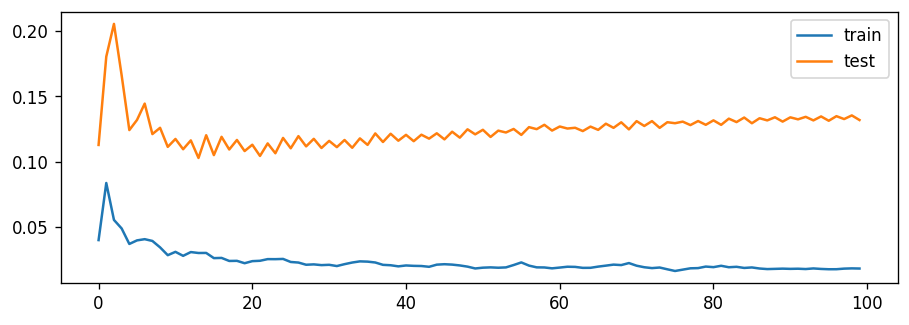

In [ ]:
# สร้าง LSTM network ด้วย library Keras โดยกำหนดขนาด hidden layer(100) และ shape ของข้อมูล input(#rows x #features)
model4 = Sequential()
model4.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
# สร้าง hidden layer ตามขนาด output หรือ จำนวนวันที่ต้องการ forecast (7) 
model4.add(Dense(7))
model4.compile(loss='mae', optimizer='adam')

# train โมเดล และเก็บ log
history = model4.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# พล็อตค่า train&test loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

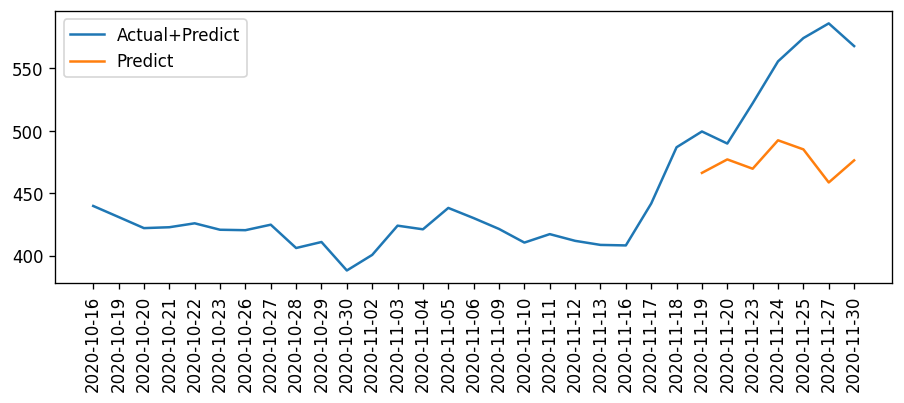

In [ ]:
# ทำ prediction
yhat = model4.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# rescale ข้อมูลกลับ
inv_yhat = yhat*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']
inv_y = test_y*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']

# พล็อตราคาจริงของวันที่ทำ prediction ล่วงหน้า 7 วัน + ราคาย้อนหลัง 30 วัน (สีน้ำเงิน) และ ราคา forecast (สีส้ม)
import numpy as np
idx = np.random.randint(0,len(yhat-7))
if idx <30:
  date_actual = date_test[:idx+7]
else:
  date_actual = date_test[idx-30:idx+7]
pyplot.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
pyplot.plot(date_actual,inv_y[max(0,idx-30):idx+7,0],label='Actual+Predict')
pyplot.plot(date_test[idx:idx+7],inv_yhat[idx],label='Predict')
pyplot.xticks(rotation=90)
pyplot.legend()
pyplot.show()

In [ ]:
forecast_accuracy(inv_yhat, inv_y)

{'corr': 0.9936721534645706,
 'mae': 88.23929454490407,
 'mape': 0.15725975186526983,
 'me': -49.255495019234424,
 'minmax': 0.15191549142793648,
 'mpe': -0.06301963378493695,
 'rmse': 104.48221665666077}

# Feature Selection with Granger causality tests

In [14]:
df_final = pd.read_csv("/content/drive/My Drive/Capstone_data/df_final2.csv")
df_final.head()

,Date,High,Low,Open,Volume,Adj Close,ema10,ema20,ema75,macd,macd_signal_line,rsi,L14,H14,%K,%D,name,COILOpen,COILHigh,COILLow,COILClose,COILAdj Close,COILVolume,DJIOpen,DJIHigh,DJILow,DJIClose,DJIAdj Close,DJIVolume,EURUSDOpen,EURUSDHigh,EURUSDLow,EURUSDClose,EURUSDAdj Close,EURUSDVolume,GOLDOpen,GOLDHigh,GOLDLow,GOLDClose,GOLDAdj Close,...,IXICAdj Close,IXICVolume,N225Open,N225High,N225Low,N225Close,N225Adj Close,N225Volume,NGFOpen,NGFHigh,NGFLow,NGFClose,NGFAdj Close,NGFVolume,NYAOpen,NYAHigh,NYALow,NYAClose,NYAAdj Close,NYAVolume,SILVEROpen,SILVERHigh,SILVERLow,SILVERClose,SILVERAdj Close,SILVERVolume,SP500Open,SP500High,SP500Low,SP500Close,SP500Adj Close,SP500Volume,USDCNYOpen,USDCNYHigh,USDCNYLow,USDCNYClose,USDCNYAdj Close,USDCNYVolume,compound,GGTrendAllTimeMonthly
0,2015-01-22,28.117500,27.430000,27.565001,215185600.0,25.597706,24.955144,25.045723,25.371346,-0.144608,-0.192319,54.163214,26.157499,28.312500,90.139232,63.747240,AAPL,47.349998,49.090000,45.869999,46.310001,46.310001,426829.0,17557.289063,17840.890625,17482.539063,17813.980469,17813.980469,111980000.0,1.161697,1.164289,1.141400,1.161535,1.161535,0.0,1293.199951,1302.099976,1283.500000,1300.699951,1300.699951,...,4750.399902,1.996550e+09,17306.640625,17355.740234,17229.210938,17329.019531,17329.019531,121900.0,3.000,3.048,2.766,2.835,2.835,169450.0,10753.580078,10869.000000,10699.730469,10859.349609,10859.349609,4.176050e+09,18.346001,18.346001,18.346001,18.346001,18.346001,0.0,2034.300049,2064.620117,2026.380005,2063.149902,2063.149902,4.176050e+09,6.2017,6.2020,6.1986,6.2017,6.2017,0.0,0.0,0.0
1,2015-01-23,28.437500,27.882500,28.075001,185859200.0,25.729790,25.095989,25.110872,25.380778,-0.072844,-0.168424,57.671228,26.157499,28.437500,91.557057,79.590968,AAPL,46.630001,47.759998,45.209999,45.590000,45.590000,374289.0,17812.500000,17812.500000,17667.529297,17672.599609,17672.599609,97110000.0,1.134649,1.137398,1.112180,1.134675,1.134675,0.0,1299.800049,1299.800049,1292.599976,1292.599976,1292.599976,...,4757.879883,1.653830e+09,17520.630859,17532.060547,17460.759766,17511.750000,17511.750000,132500.0,2.858,2.994,2.855,2.986,2.986,99068.0,10854.230469,10854.230469,10784.570313,10788.330078,10788.330078,3.573560e+09,18.315001,18.355000,18.284000,18.284000,18.284000,20.0,2062.979980,2062.979980,2050.540039,2051.820068,2051.820068,3.573560e+09,6.1990,6.2179,6.1990,6.1990,6.1990,0.0,0.0,0.0
2,2015-01-26,28.590000,28.200001,28.434999,222460000.0,25.757124,25.216195,25.172420,25.390682,-0.013608,-0.137461,66.442618,26.157499,28.590000,87.050342,89.582210,AAPL,45.200001,46.410000,44.349998,45.150002,45.150002,310638.0,17668.109375,17696.359375,17567.599609,17678.699219,17678.699219,87220000.0,1.114082,1.128399,1.114082,1.112545,1.112545,0.0,1289.500000,1290.599976,1279.400024,1279.400024,1279.400024,...,4771.759766,1.717510e+09,17285.710938,17471.939453,17285.710938,17468.519531,17468.519531,111600.0,2.897,2.955,2.841,2.881,2.881,62580.0,10787.299805,10848.040039,10748.730469,10847.150391,10847.150391,3.465760e+09,17.966999,17.966999,17.966999,17.966999,17.966999,0.0,2050.419922,2057.620117,2040.969971,2057.090088,2057.090088,3.465760e+09,6.2179,6.2458,6.2179,6.2179,6.2179,0.0,0.0,0.0
3,2015-01-27,28.120001,27.257500,28.105000,382274800.0,24.855284,25.150575,25.142216,25.376593,-0.038984,-0.117766,55.811122,26.299999,28.590000,43.013110,73.873503,AAPL,45.130001,46.549999,44.810001,46.230000,46.230000,313141.0,17638.529297,17638.529297,17288.310547,17387.210938,17387.210938,135940000.0,1.125100,1.142000,1.122600,1.124771,1.124771,0.0,1277.199951,1291.699951,1277.199951,1291.699951,1291.699951,...,4681.500000,1.954160e+09,17649.400391,17768.410156,17633.470703,17768.300781,17768.300781,139700.0,2.895,3.005,2.888,2.981,2.981,55623.0,10793.040039,10830.200195,10718.849609,10781.830078,10781.830078,3.329810e+09,18.110001,18.110001,18.068001,18.068001,18.068001,10.0,2047.859985,2047.859985,2019.910034,2029.550049,2029.550049,3.329810e+09,6.2458,6.2458,6.2351,6.2458,6.2

In [15]:
# get list of stock name
sp500list = pd.read_csv("/content/drive/My Drive/sp500symbol.csv",usecols = ['Symbol'])['Symbol'].to_list()
sp500list[:5]

['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL']

In [18]:
# separate each stock to it own file
for i in sp500list:
  df_final_each_stock=df_final[(df_final['name']==i)&((df_final['Date']>='2019-01-01')&(df_final['Date']<='2020-12-25'))]
  df_final_each_stock.drop(columns='name',inplace=True)
  df_final_each_stock.to_csv("/content/drive/My Drive/Capstone_data/sp500combine/"+i+"_combine.csv",index = False)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



In [12]:
# get list of stock name
sp500list = pd.read_csv("/content/drive/My Drive/sp500symbol.csv",usecols = ['Symbol'])['Symbol'].to_list()
sp500list[:5]

['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL']

In [19]:
sp500list_combine = [i + '_combine' for i in sp500list] 

for i in sp500list_combine:
  df=pd.read_csv('/content/drive/My Drive/Capstone_data/sp500combine/'+i+'.csv')
  df.set_index('Date',inplace=True)
  
  p_value_m=grangers_causation_matrix(df, variables = df.columns)
  
  p_value_adj_close=p_value_m.loc[['Adj Close_y']]
  p_value_adj_close_t = p_value_adj_close.transpose()
  
  select_feature=p_value_adj_close_t[p_value_adj_close_t['Adj Close_y']<0.05]
  select_feature=select_feature.sort_values(by=['Adj Close_y'],ascending=True).iloc[0:20]
  select_feature_list=select_feature.index.values.tolist()
  select_feature_list.extend(['Adj Close'])
  select_feature_list=[w.replace("_x","") for w in select_feature_list]
  df_feature=df[select_feature_list]
  df_feature.reset_index(inplace=True)
  df_feature.to_csv('/content/drive/My Drive/Capstone_data/sp500featureselection/'+i+'_feature.csv',index=False)

## Temp switch back to local dev

In [14]:
sp500list = df_final['name'].unique()
sp500list = list(sp500list)
sp500list[:5]

['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL']

In [23]:
sp500list_combine = [i + '_combine' for i in sp500list] 

for i in sp500list_combine:
  df=pd.read_csv(datapath+"/03sepstock_combine/"+i+".csv")
  df.set_index('Date',inplace=True)
  
  p_value_m=grangers_causation_matrix(df, variables = df.columns)
  
  p_value_adj_close=p_value_m.loc[['Adj Close_y']]
  p_value_adj_close_t = p_value_adj_close.transpose()
  
  select_feature=p_value_adj_close_t[p_value_adj_close_t['Adj Close_y']<0.05]
  select_feature=select_feature.sort_values(by=['Adj Close_y'],ascending=True).iloc[0:20]
  select_feature_list=select_feature.index.values.tolist()
  select_feature_list.extend(['Adj Close'])
  select_feature_list=[w.replace("_x","") for w in select_feature_list]
  df_feature=df[select_feature_list]
  df_feature.reset_index(inplace=True)
  df_feature.to_csv(datapath+"/04stock_feature/"+i+'_feature.csv',index=False)

 constraints is 10, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/mnt/c/Users/poom/drive/72client/miniconda3/envs/stock_ai/lib/python3.6/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/mnt/c/Users/poom/drive/72client/miniconda3/envs/stock_ai/lib/python3.6/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/mnt/c/Users/poom/drive/72client/miniconda3/envs/stock_ai/lib/python3.6/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  'rank is %d' % (J, J_), ValueWarning)
/mnt/c/Users/poom/drive/72client/miniconda3/envs/stock_ai/lib/python3.6/site-packages/statsmodels/base/model.py:1834:

KeyboardInterrupt: 

## Model MultiStep Multi variate LSTM all stock

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [22]:
#time series process from 3D data to 2D
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [23]:
def list_drop_fea(dataset,previous,predict):
  feature=len(dataset.columns)
  list_drop=[]
  for i in range(0,(feature*(previous+predict))):
   if i < (previous*feature):
      continue
   elif (i-(feature-1))%feature != 0:
      list_drop.append(i)
   else :
      continue
  return list_drop

In [25]:
sp500list[:5]

['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL']

In [26]:
name_set100_feature = [i + '_combine_feature' for i in sp500list] 

In [27]:
stock_predict=pd.DataFrame()

for i in name_set100_feature:
  set100_df_short =pd.read_csv("/content/drive/My Drive/Capstone_data/sp500featureselection/"+i+".csv")
  set100_df_short.set_index('Date',inplace=True)
  dataset = set100_df_short
  values = dataset.values
  values = values.astype('float32')
  # ทำ scaling ข้อมูลด้วยวิธี min max scaling เปลี่ยน scale ข้อมูลแต่ละ column ให้อยู่ระหว่าง [0,1] และเก็บค่า min max แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
  min_dict = dict()
  max_dict = dict()
  for col in dataset.columns:
    min_dict[col] = dataset[col].min()
    max_dict[col] = dataset[col].max()
    dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())
  # ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้
  reframed = series_to_supervised(dataset.values, 30, 10 ,feat_name=dataset.columns)
  
  #Drop feature list ratede previous time step and Next Time Step 
  feature_Drop=list_drop_fea(dataset,30,10)
  reframed.drop(reframed.columns[feature_Drop], axis=1, inplace=True)
  values = reframed.values
  n_train_percent = 0.8
  split = int(values.shape[0]*n_train_percent)
  train = values[:split, :]
  test = values[split:, :]
  
  # เก็บค่า datetime ของ train & test
  date_reframed = dataset.index[reframed.index]
  date_train = date_reframed[:split]
  date_test = date_reframed[split:]
  
  # split feature และ target
  train_X, train_y = train[:, :-10], train[:, -10:]
  test_X, test_y = test[:, :-10], test[:, -10:]
  
  # reshape input ให้เป็น 3D (samples, timesteps, features)
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  # สร้าง LSTM network ด้วย library Keras โดยกำหนดขนาด hidden layer(100) และ shape ของข้อมูล input(#rows x #features)
  
  model4 = Sequential()
  model4.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
  # สร้าง hidden layer ตามขนาด output หรือ จำนวนวันที่ต้องการ forecast (10) 
  model4.add(Dense(10))
  model4.compile(loss='mae', optimizer='adam')
  # train โมเดล และเก็บ log
  history = model4.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
  yhat = model4.predict(test_X)
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  # rescale ข้อมูลกลับ
  inv_yhat = yhat*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']
  inv_y = test_y*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']
  list_yhat=inv_yhat[-1:]
  df = pd.DataFrame(list_yhat,)
  df['name']=i
  stock_predict=stock_predict.append(df)

Streaming output truncated to the last 5000 lines.
6/6 - 0s - loss: 0.1005 - val_loss: 0.1528
Epoch 14/100
6/6 - 0s - loss: 0.0956 - val_loss: 0.1514
Epoch 15/100
6/6 - 0s - loss: 0.0955 - val_loss: 0.1655
Epoch 16/100
6/6 - 0s - loss: 0.0975 - val_loss: 0.1540
Epoch 17/100
6/6 - 0s - loss: 0.0950 - val_loss: 0.1787
Epoch 18/100
6/6 - 0s - loss: 0.0887 - val_loss: 0.1802
Epoch 19/100
6/6 - 0s - loss: 0.0887 - val_loss: 0.1881
Epoch 20/100
6/6 - 0s - loss: 0.0935 - val_loss: 0.1894
Epoch 21/100
6/6 - 0s - loss: 0.0890 - val_loss: 0.2048
Epoch 22/100
6/6 - 0s - loss: 0.0897 - val_loss: 0.1761
Epoch 23/100
6/6 - 0s - loss: 0.0881 - val_loss: 0.1844
Epoch 24/100
6/6 - 0s - loss: 0.0933 - val_loss: 0.2159
Epoch 25/100
6/6 - 0s - loss: 0.0953 - val_loss: 0.1574
Epoch 26/100
6/6 - 0s - loss: 0.0818 - val_loss: 0.1992
Epoch 27/100
6/6 - 0s - loss: 0.0827 - val_loss: 0.2072
Epoch 28/100
6/6 - 0s - loss: 0.0855 - val_loss: 0.1909
Epoch 29/100
6/6 - 0s - loss: 0.0863 - val_loss: 0.2261
Epoch 30/1

FileNotFoundError: ignored

In [ ]:
 inv_yhat[-1:]

In [ ]:
stock_predict.to_csv('/content/drive/My Drive/Capstone_data/stock_predict.csv')